In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### 1c1) **Bubble wake & shape**
The Reynolds number of the flow in the TMHT channel is given by $$\mathrm{Re} = \frac{\rho_c U L}{\mu},$$ where, at $20$ $\text{°C}$, the density of water is $\rho_c=998,2071$ $\text{kg/m}^3$, and its viscosity is $\mu=1.0016$ $\text{mPa s}$. The velocity of the flow is $U=0.5$ $\text{m/s}, and as a characteristic length scale we choose the length of the measurement section, which is $L=1000$ $\text{mm}$.

In [2]:
rho_c = 998.2071    # kg/m^3
U = 0.5             # m/s
L = 1.0             # m
mu_c = 1.0016e-3    # Pa s

Re = rho_c * U * L / mu_c
print(Re)

498306.2599840255


TODO: This is too large to read on the chart?

Finally, the Bond (or Eötvös) number is $$\mathrm{Bo} = \frac{\Delta\rho g L^2}{\sigma}$$

In [3]:
rho_a = 1.293      # kg/m3 (@ 20°C)
g = 9.81              # m/s2
sigma = 72.8 * 10**-3 # N/m (https://www.nanoscience.com/techniques/tensiometry/surface-and-interfacial-tension/)

Bo = (rho_c - rho_a) * g * L**2 / sigma
print(Bo)

134336.91375


Again, too large for the chart. TODO: what is going wrong?

The Morton number is given by $$\mathrm{Mo}=\frac{g \mu_c^4 \Delta\rho}{\rho_c^2 \sigma^3}$$

In [4]:
Mo = g * mu_c**4 * (rho_c - rho_a) / (rho_c**2 * sigma**3)
print(np.log10(Mo))

-10.591731437685036


This value is on the chart, but how to match it with the other two numbers?

Properties given in the exercise but unused for some reason, a bit sus (TODO):

In [5]:
fr = 10*60*1e-3    # m3/s
tr = 0.007          # s
Ub = 1.2 * U       # m/s

### 1c2) **Mean, standard error and PDF**
Start by calibrating the resistance measurements by fitting the Steinhart-Hart equation again.

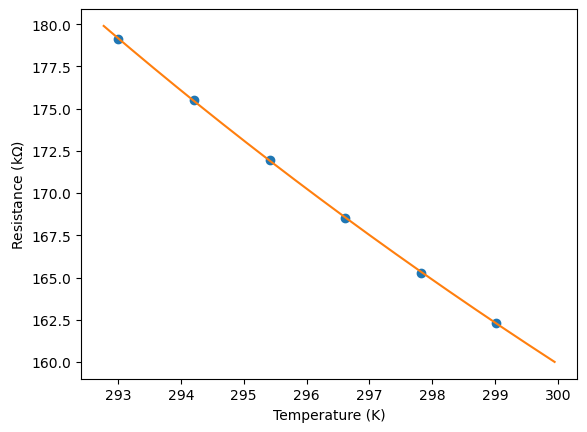

In [6]:
# Import ThermExperCalib.csv
[T_cal, R_cal] = np.squeeze(
    np.split(np.loadtxt('Data/ThermExperCalib.csv', delimiter=','), 2, axis=1))

# Plot the data
plt.plot(T_cal, R_cal/1000, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (k$\Omega$)')

# Fit the Steinhart-Hart equation to the datapoints


def steinhart_hart(R, A, B, C):
    T_inv = A + B * np.log(R) + C * (np.log(R)**3)
    return T_inv


def calc_temp(R, A, B, C):
    T = 1/steinhart_hart(R, A, B, C)
    return T


[A, B, C] = curve_fit(steinhart_hart, R_cal, 1/T_cal)[0]


R_test = np.arange(160000, 180000, 100)
plt.plot(calc_temp(R_test, A, B, C), R_test/1000)
plt.show()

Next, we import the data, and calculate the temperature using the function defined above. We can directly obtain the mean and standard deviation of the signals.

In [7]:
# Import data
R_bub = np.loadtxt('Data/ThermBubData.csv', delimiter=',')
R_nobub = np.loadtxt('Data/ThermNoBubData.csv', delimiter=',')

# Calculate temperature
T_bub = calc_temp(R_bub, A, B, C)
T_nobub = calc_temp(R_nobub, A, B, C)

# Calculate and print statistics
T_mean_bub, T_std_bub = [np.mean(T_bub), np.std(T_bub)]
T_mean_nobub, T_std_nobub = [np.mean(T_nobub), np.std(T_nobub)]

print('Mean temperature (+- std) with bubbles: {:.3f} +- {:.3f}'.format(
    T_mean_bub, T_std_bub)
    + '\n                       without bubbles: {:.3f} +- {:.3f}'.format(
        T_mean_nobub, T_std_nobub))


Mean temperature (+- std) with bubbles: 295.796 +- 0.032
                       without bubbles: 295.810 +- 0.035


Next, we calculate the PDFs, centre the bins that were output by the `np.histogram` function, and plot the results.

The number of bins that will be used is based on #TODO Explain reasoning.

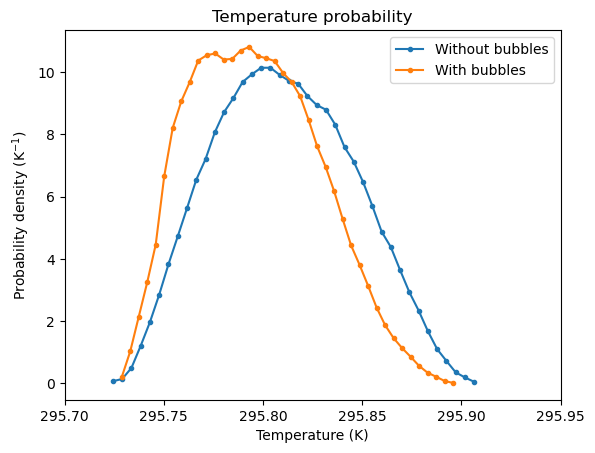

In [8]:
# Calculate the probabiliy density function of the data
n_bins = 40

pdf_bub, bins_bub = np.histogram(T_bub, bins=n_bins, density=True)
bin_centers_bub = 0.5*(bins_bub[1:] + bins_bub[:-1])

pdf_nobub, bins_nobub = np.histogram(T_nobub, bins=n_bins, density=True)
bin_centers_nobub = 0.5*(bins_nobub[1:] + bins_nobub[:-1])

plt.plot(bin_centers_nobub, pdf_nobub, '.-', label='Without bubbles')
plt.plot(bin_centers_bub, pdf_bub, '.-', label='With bubbles')

plt.xlim([295.7, 295.95])
plt.legend()
plt.title('Temperature probability')
plt.xlabel('Temperature (K)')
plt.ylabel('Probability density (K$^{-1}$)')
plt.show()

We can check whether these PDFs are properly normalised: the probability of having *any* temperature should be equal to $100\%$, so $\int^{\infty}_{-\infty} PDF(x) \mathrm{d}x=1$.

In [9]:
print('The total probabilities of the above pdfs are '
      + str(np.sum(pdf_bub * (bins_bub[1] - bins_bub[0]))) + ' and '
      + str(np.sum(pdf_nobub * (bins_nobub[1] - bins_nobub[0]))) + ', respectively.')

The total probabilities of the above pdfs are 0.9999999999980371 and 0.9999999999975694, respectively.


### 1c3) **Power spectra**

The number of pieces in which we have split the signal when applying the Bartlett method is such that as much noise as possible is averaged out, while still having sufficiently many data points to see the start of the inertial range at around $1 \rm{Hz}$. 

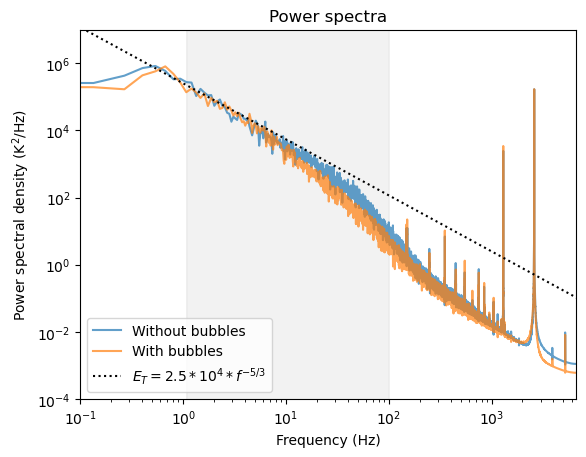

In [10]:
def bartlett_fft(signal, fs, n_pieces):
    # Cut the signal into n equally-sized pieces
    signal_list = np.split(signal, n_pieces)
    P_list = []

    # Calculate power spectrum of each piece
    for piece in signal_list:
        P_list.append(np.abs(np.fft.fft(piece))**2)
        
    # Calculate the average power spectrum
    P_av = np.mean(P_list, axis=0)

    # Calculate the frequency array
    f = np.fft.fftfreq(piece.size, 1/fs)
    idx = np.argsort(f)

    # Get only positive frequencies
    f, P_av = f[idx], P_av[idx]

    return f, P_av

fs = 13.39*1e3     # Hz
n_pieces = 10

f, PS_nobub = bartlett_fft(T_nobub, fs, n_pieces)
f, PS_bub = bartlett_fft(T_bub, fs, n_pieces)

f_slope = np.logspace(-2,4,100)
PS_slope = 25e4*f_slope**(-5/3)

fig, ax = plt.subplots()
plt.loglog(f, PS_nobub, '-', alpha=0.7, label='Without bubbles')
plt.loglog(f, PS_bub, '-', alpha=0.7, label='With bubbles')
plt.loglog(f_slope, PS_slope, ':', color='k', label='$E_T = 2.5*10^4*f^{-5/3}$')
ax.fill_between(f, 1e-4, 1e7, where=(f > 1) & (f < 100), color='gray', alpha=0.1)

plt.xlim([0.1, fs/2])
plt.ylim([1e-4, 1e7])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (K$^2$/Hz)')
plt.title('Power spectra')
plt.show()

From the above plot, we can see that the power spectrum starts to decay faster than $E_T\propto f^{-5/3}$ when bubbles are present in the flow. In other words, the bubbles suppress higher frequency temperature fluctuations TODO: finish this explanation!!